# Modeling 1: Make a quick fit using astropy.modeling

- https://learn.astropy.org/tutorials/Models-Quick-Fit.html

Learning Goals
- Use astroquery to download data from Vizier
- Use basic models in astropy.modeling
- Learn common functions to fit
- Generate a quick fit to data
- Plot the model with the data
- Compare different models and fitters

## Summary
In this tutorial, we will become familiar with the models available in [astropy.modeling](http://docs.astropy.org/en/stable/modeling/) and learn how to make a quick fit to our data.

## Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting
from astroquery.vizier import Vizier
import scipy.optimize
# Make plots display in notebooks
%matplotlib inline 

## 1) Fit a Linear model: Three steps to fit data using astropy.modeling

We are going to start with a linear fit to real data. The data comes from the paper [Bhardwaj et al. 2017](https://ui.adsabs.harvard.edu/?#abs/2017A%26A...605A.100B). This is a catalog of Type II Cepheids, which is a type of variable stars that pulsate with a period between 1 and 50 days. In this part of the tutorial, we are going to measure the Cepheids Period-Luminosity relation using astropy.modeling. This relation states that if a star has a longer period, the luminosity we measure is higher.

To get it, we are going to import it from [Vizier](http://vizier.u-strasbg.fr/viz-bin/VizieR) using [astroquery](http://astroquery.readthedocs.io/en/latest/vizier/vizier.html).

In [ ]:
catalog = Vizier.get_catalogs('J/A+A/605/A100')

In [ ]:
catalog

TableList with 1 tables:
	'0:J/A+A/605/A100/table1' with 16 column(s) and 50 row(s) 

This catalog has a lot of information, but for this tutorial we are going to work only with periods and magnitudes. Let's grab them using the keywords `'Period'` and `__Ksmag__`. Note that `e__Ksmag_` refers to the error bars in the magnitude measurements.

In [ ]:
period = np.array(catalog[0]['Period']) 
log_period = np.log10(period)
k_mag = np.array(catalog[0]['__Ksmag_'])
k_mag_err = np.array(catalog[0]['e__Ksmag_'])

Let's take a look at the magnitude measurements as a function of period:

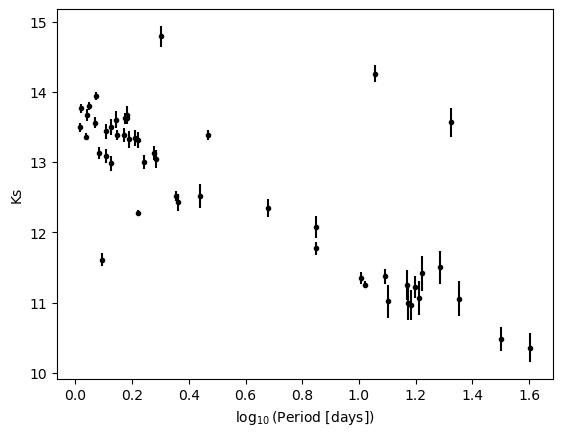

In [ ]:
plt.errorbar(log_period, k_mag, k_mag_err, fmt='k.')
plt.xlabel(r'$\log_{10}$(Period [days])')
plt.ylabel('Ks')
plt.show()

One could say that there is a linear relationship between log period and magnitudes. To probe it, we want to make a fit to the data. This is where astropy.modeling is useful. We are going to understand how in three simple lines we can make any fit we want. We are going to start with the linear fit, but first, let's understand what a model and a fitter are.

### Models in Astropy

[Models](http://docs.astropy.org/en/stable/modeling/#using-models) in Astropy are known parametrized functions. With this format they are easy to define and to use, given that we do not need to write the function expression every time we want to use a model, just the name. They can be linear or non-linear in the variables. Some examples of models are:

- Gaussian1D
- Trapezoid1D
- Polynomial1D
- Sine1D
- Linear1D
- The [list](http://docs.astropy.org/en/stable/modeling/#module-astropy.modeling.functional_models) continues.

### Fitters in Astropy

Fitters in Astropy are the classes resposable for making the fit. They can be linear or non-linear in the parameters (no the variable, like models). Some examples are:

- LevMarLSQFitter() Levenberg-Marquardt algorithm and least squares statistic.
- LinearLSQFitter() A class performing a linear least square fitting.
- SLSQPLSQFitter() SLSQP optimization algorithm and least squares statistic.
- SimplexLSQFitter() Simplex algorithm and least squares statistic.
- More detailles [here](http://docs.astropy.org/en/stable/modeling/#id21)

Now we continue with our fitting.

#### Step 1: Model

First we need to choose which model we are going to use to fit to our data. As we said before, our data looks like a linear relation, so we are going to use a linear model.

In [ ]:
model = models.Linear1D()

#### Step 2: Fitter

Second we are going to choose the fitter we want to use. This choice is basically which method we want to use to fit the model to the data. In this case we are going to use the [Linear Least Square Fitting](https://www.mathworks.com/help/curvefit/least-squares-fitting.html).

In [ ]:
fitter = fitting.LinearLSQFitter() 

#### Step 3: Fit Data

Finally, we give to our fitter (method to fit the data) the model and the data to perform the fit. Note that we are including weights: This means that values with higher error will have smaller weight (less importance) in the fit, and the contrary for data with smaller errors. This way of fitting is called *Weighted Linear Least Squares* and you can find more information about it [here](https://www.mathworks.com/help/curvefit/least-squares-fitting.html) or [here](https://en.wikipedia.org/wiki/Least_squares#Weighted_least_squares). Note that the fitting routine takes weights as 1/error and squares them for you, as indicated [in the description of the function](https://docs.astropy.org/en/stable/api/astropy.modeling.fitting.LinearLSQFitter.html).

In [ ]:
best_fit = fitter(model, log_period, k_mag, weights=1.0/k_mag_err)
print(best_fit)

Model: Linear1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
           slope            intercept     
    ------------------- ------------------
    -1.8388029852166523 13.517530403506656


And that's it!

We can evaluate the fit at our particular x axis by doing best_fit(x).

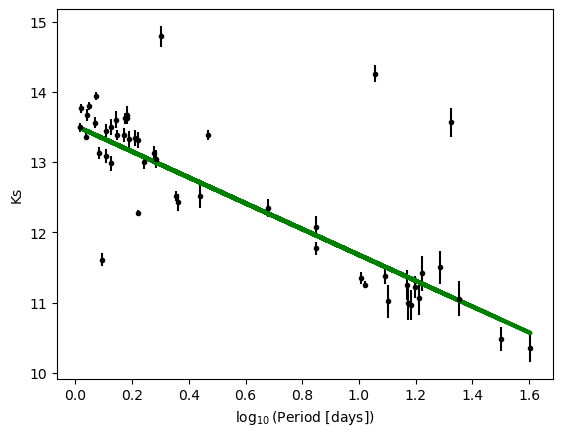

In [ ]:
plt.errorbar(log_period,k_mag,k_mag_err,fmt='k.')
plt.plot(log_period, best_fit(log_period), color='g', linewidth=3)  
plt.xlabel(r'$\log_{10}$(Period [days])')
plt.ylabel('Ks')
plt.show()

**Conclusion**: Remember, you can fit data with three lines of code:

1. Choose a model.
1. Choose a fitter.
1. Pass to the fitter the model and the data to perform fit.

## 2) Fit a Polynomial model: Choose fitter wisely

For our second example, let's fit a polynomial of degree more than 1. In this case, we are going to create fake data to make the fit. Note that we're adding gaussian noise to the data with the function np.random.normal(0,2) which gives a random number from a gaussian distribution with mean 0 and standard deviation 2.

In [ ]:
N = 100
x1 = np.linspace(0, 4, N)  # Makes an array from 0 to 4 of N elements
y1 = x1**3 - 6*x1**2 + 12*x1 - 9 
# Now we add some noise to the data
y1 += np.random.normal(0, 2, size=len(y1)) #One way to add random gaussian noise
sigma = 1.5
y1_err = np.ones(N)*sigma 

Let's plot it to see how it looks:

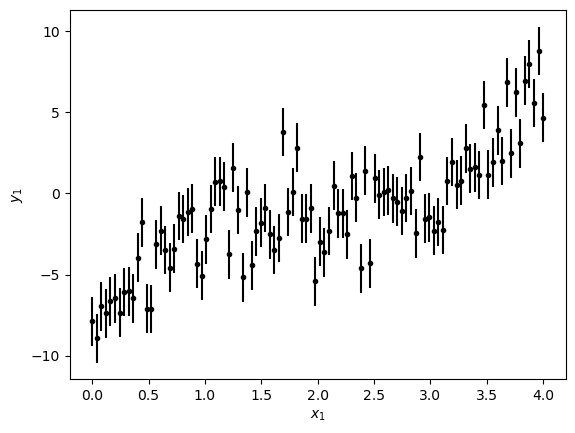

In [ ]:
plt.errorbar(x1, y1, yerr=y1_err,fmt='k.')
plt.xlabel('$x_1$')  
plt.ylabel('$y_1$')
plt.show()

To fit this data let's remember the three steps: model, fitter and perform fit.

In [ ]:
model_poly = models.Polynomial1D(degree=3)
fitter_poly = fitting.LinearLSQFitter() 
best_fit_poly = fitter_poly(model_poly, x1, y1, weights = 1.0/y1_err)

In [ ]:
print(best_fit_poly)

Model: Polynomial1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 3
Parameters:
            c0                 c1                c2                 c3        
    ------------------ ----------------- ------------------ ------------------
    -8.743368681990052 11.76837380718059 -6.121982887512795 1.0490823373233873


What would happend if we use a different fitter (method)? Let's use the same model but with SimplexLSQFitter as fitter.

In [ ]:
fitter_poly_2 = fitting.SimplexLSQFitter()
best_fit_poly_2 = fitter_poly_2(model_poly, x1, y1, weights = 1.0/y1_err)

In [ ]:
print(best_fit_poly_2)

Model: Polynomial1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 3
Parameters:
             c0                   c1                   c2                 c3        
    ------------------- --------------------- ------------------- ------------------
    -0.4034817063481736 -0.047841901591253684 -1.3029831279992647 0.4494626105702417


Note that we got a warning after using SimplexLSQFitter to fit the data. The first line says:
```
WARNING: Model is linear in parameters; consider using linear fitting methods. [astropy.modeling.fitting]
```

If we look at the model we chose: $y = c_0 + c_1 \times x + c_2 \times x^2 + c_3 \times x^3$, it is linear in the parameters $c_i$. The warning means that SimplexLSQFitter works better with models that are not linear in the parameters, and that we should use a linear fitter like LinearLSQFitter. The second line says:
```
WARNING: The fit may be unsuccessful; Maximum number of iterations reached. [astropy.modeling.optimizers]
```

So it's not surprising that the results are different, because this means that the fitter is not working properly. Let's discuss a method of choosing between fits and remember to pay attention when you choose the fitter.

### Compare results

One way to check which model parameters are a better fit is calculating the [Reduced Chi Square Value](https://en.wikipedia.org/wiki/Reduced_chi-squared_statistic). Let's define a function to do that because we're going to use it several times.

In [ ]:
def calc_reduced_chi_square(fit, x, y, yerr, N, n_free):
    '''
    fit (array) values for the fit
    x,y,yerr (arrays) data
    N total number of points
    n_free number of parameters we are fitting
    '''
    return 1.0/(N-n_free)*sum(((fit - y)/yerr)**2)

In [ ]:
reduced_chi_squared = calc_reduced_chi_square(best_fit_poly(x1), x1, y1, y1_err, N, 4)
print('Reduced Chi Squared with LinearLSQFitter: {}'.format(reduced_chi_squared))

Reduced Chi Squared with LinearLSQFitter: 1.524068567289388


In [ ]:
reduced_chi_squared = calc_reduced_chi_square(best_fit_poly_2(x1), x1, y1, y1_err, N, 4)
print('Reduced Chi Squared with SimplexLSQFitter: {}'.format(reduced_chi_squared))

Reduced Chi Squared with SimplexLSQFitter: 4.049251347082743


As we can see, the Reduced Chi Square for the first fit is closer to one, which means this fit is better. Note that this is what we expected after the discussion of the warnings.

We can also compare the two fits visually:

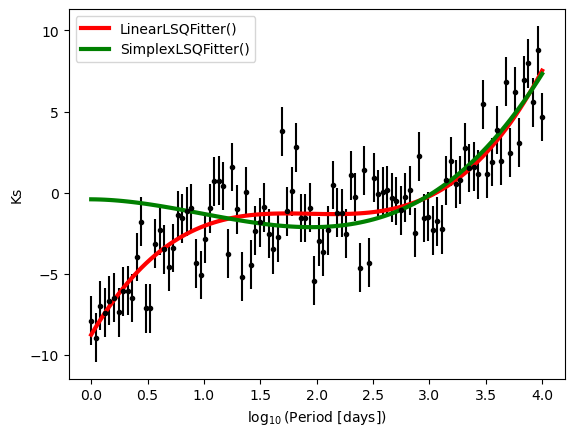

In [ ]:
plt.errorbar(x1, y1, yerr=y1_err,fmt='k.')
plt.plot(x1, best_fit_poly(x1), color='r', linewidth=3, label='LinearLSQFitter()')  
plt.plot(x1, best_fit_poly_2(x1), color='g', linewidth=3, label='SimplexLSQFitter()')
plt.xlabel(r'$\log_{10}$(Period [days])')
plt.ylabel('Ks')
plt.legend()
plt.show()

Results are as espected, the fit performed with the linear fitter is better than the second, non linear one.

**Conclusion**: Pay attention when you choose the fitter.

## 3) Fit a Gaussian: Let's compare to scipy

Scipy has the function [scipy.optimize.curve_fit](https://docs.scipy.org/doc/scipy-1.0.0/reference/generated/scipy.optimize.curve_fit.html) to fit in a similar way that we are doing. Let's compare the two methods with fake data in the shape of a Gaussian.

In [ ]:
mu, sigma, amplitude = 0.0, 10.0, 10.0
N2 = 100
x2 = np.linspace(-30, 30, N)
y2 = amplitude * np.exp(-(x2-mu)**2 / (2*sigma**2))
y2 = np.array([y_point + np.random.normal(0, 1) for y_point in y2])   #Another way to add random gaussian noise
sigma = 1
y2_err = np.ones(N)*sigma

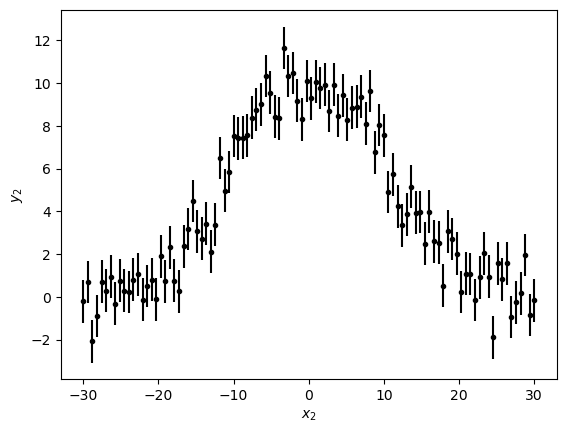

In [ ]:
plt.errorbar(x2, y2, yerr=y2_err, fmt='k.')
plt.xlabel('$x_2$')
plt.ylabel('$y_2$')
plt.show()

Let's do our three steps to make the fit we want. For this fit we're going to use a non-linear fitter, LevMarLSQFitter, because the model we need (Gaussian1D) is non-linear in the parameters.

In [ ]:
model_gauss = models.Gaussian1D()
fitter_gauss = fitting.LevMarLSQFitter()
best_fit_gauss = fitter_gauss(model_gauss, x2, y2, weights=1/y2_err)

In [ ]:
print(best_fit_gauss)

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude              mean              stddev     
    ------------------ ------------------- -----------------
    10.337206361388123 0.18808651513947255 9.922106277380372


We can get the [covariance matrix](http://mathworld.wolfram.com/CovarianceMatrix.html) from LevMarLSQFitter, which provides an error for our fit parameters by doing `fitter.fit_info['param_cov']`. The elements in the diagonal of this matrix are the square of the errors. We can check the order of the parameters using:

In [ ]:
model_gauss.param_names

('amplitude', 'mean', 'stddev')

In [ ]:
cov_diag = np.diag(fitter_gauss.fit_info['param_cov'])
print(cov_diag)

[0.05173467 0.06352036 0.06369287]


Then:

In [ ]:
print('Amplitude: {} +\- {}'.format(best_fit_gauss.amplitude.value, np.sqrt(cov_diag[0])))
print('Mean: {} +\- {}'.format(best_fit_gauss.mean.value, np.sqrt(cov_diag[1])))
print('Standard Deviation: {} +\- {}'.format(best_fit_gauss.stddev.value, np.sqrt(cov_diag[2])))

Amplitude: 10.337206361388123 +\- 0.22745256392662278
Mean: 0.18808651513947255 +\- 0.25203245656113715
Standard Deviation: 9.922106277380372 +\- 0.2523744652907493


We can apply the same method with scipy.optimize.curve_fit, and compare the results using again the Reduced Chi Square Value.

In [ ]:
def f(x,a,b,c):
    return a * np.exp(-(x-b)**2/(2.0*c**2))

In [ ]:
p_opt, p_cov = scipy.optimize.curve_fit(f,x2, y2, sigma=y1_err)
a,b,c = p_opt
best_fit_gauss_2 = f(x2,a,b,c)

In [ ]:
print(p_opt)

[10.33720537  0.18808547  9.92210818]


In [ ]:
print('Amplitude: {} +\- {}'.format(p_opt[0], np.sqrt(p_cov[0,0])))
print('Mean: {} +\- {}'.format(p_opt[1], np.sqrt(p_cov[1,1])))
print('Standard Deviation: {} +\- {}'.format(p_opt[2], np.sqrt(p_cov[2,2])))

Amplitude: 10.337205372222536 +\- 0.22612516742255181
Mean: 0.18808547032026227 +\- 0.2505609644936265
Standard Deviation: 9.922108177722457 +\- 0.2509009031996842


### Compare results

In [ ]:
reduced_chi_squared = calc_reduced_chi_square(best_fit_gauss(x2), x2, y2, y2_err, N2, 3)
print('Reduced Chi Squared using astropy.modeling: {}'.format(reduced_chi_squared))

Reduced Chi Squared using astropy.modeling: 0.9883603573294014


In [ ]:
reduced_chi_squared = calc_reduced_chi_square(best_fit_gauss_2, x2, y2, y2_err, N2, 3)
print('Reduced Chi Squared using scipy: {}'.format(reduced_chi_squared))

Reduced Chi Squared using scipy: 0.9883603573264075


As we can see there is a very small difference in the Reduced Chi Squared. This actually needed to happen, because the fitter in astropy.modeling uses scipy to fit. The advantage of using astropy.modeling is you only need to change the name of the fitter and the model to perform a completely different fit, while scipy require us to remember the expression of the function we wanted to use.

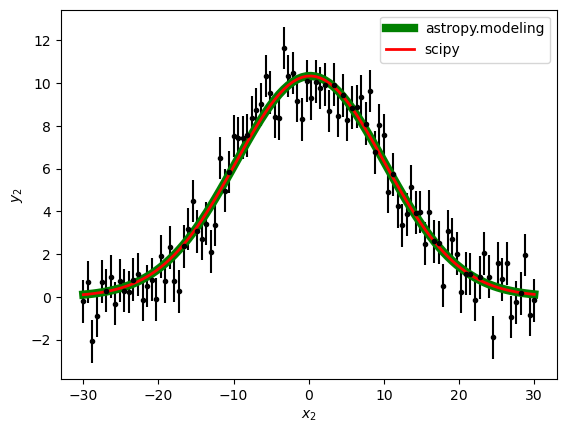

In [ ]:
plt.errorbar(x2, y2, yerr=y2_err, fmt='k.')
plt.plot(x2, best_fit_gauss(x2), 'g-', linewidth=6, label='astropy.modeling')
plt.plot(x2, best_fit_gauss_2, 'r-', linewidth=2, label='scipy')
plt.xlabel('$x_2$')
plt.ylabel('$y_2$')
plt.legend()
plt.show()

**Conclusion**: Choose the method most convenient for every case you need to fit. We recomend astropy.modeling because is easier to write the name of the function you want to fit than to remember the expression every time we want to use it. Also, astropy.modeling becomes useful with more complicated models like two gaussians plus a black body, but that is another tutorial.

## Summary:
Let's review the conclusion we got in this tutorial:

1. You can fit data with three lines of code:
    - model
    - fitter
    - perform fit to data
1. Pay attention when you choose the fitter.
1. Choose the method most convenient for every case you need to fit. We recomend astropy.modeling to make quick fits of known functions.